### Load packages

Import Python packages that are used for the analysis.

In [19]:
%matplotlib inline

import datacube
import rasterio.features as feat
import xarray as xr
import geopandas as gpd
import numpy as np
from deafrica_tools.plotting import display_map
from matplotlib import pyplot as plt

### Connect to the datacube

In [15]:
dc = datacube.Datacube(app="rainfall_chirps")

### Analysis parameters

This section defines the analysis parameters, including 

* `lat, lon, buffer`: center lat/lon and analysis window size for the area of interest
* `time_period`: time period to be investigated
* `output_crs`: projection for loading data; output resolution is not defined so different resolutions can be used for Landsat and Sentinel-2

The default location cover all of Madagascar

In [16]:
lat, lon = -18.7557, 46.8644  # Madagascar

buffer_lat, buffer_lon = 7, 4

time_period = "2020"

#output_crs = "epsg:6933"
output_crs = "epsg:6933"

# join lat,lon,buffer to get bounding box
lon_range = (lon - buffer_lon, lon + buffer_lon)
lat_range = (lat + buffer_lat, lat - buffer_lat)

## View the selected location

The next cell will display the selected area on an interactive map. Feel free to zoom in and out to get a better understanding of the area you'll be analysing. Clicking on any point of the map will reveal the latitude and longitude coordinates of that point.

In [17]:
display_map(lon_range, lat_range, crs="EPSG:4326")

## Load CHIRPS data using `dc.load()`

Now that we know what products and measurements are available for the products, we can load data from the datacube using `dc.load`. 

In the first example below, we will load CHIRPS data for region covering Madagascar

> Note: For a more general discussion of how to load data using the datacube, refer to the [Introduction to loading data](../Beginners_guide/03_Loading_data.ipynb) notebook.

In [40]:
ds_rf_month = dc.load(
    product="rainfall_chirps_monthly",
    time="2020",
    y=lat_range,
    x=lon_range,
    resolution=(-5000, 5000),
    output_crs = output_crs,
)

ndvi = ds_rf_month.rainfall
sf = gpd.read_file('./Datasets/ocha_commune.shp')
sf = sf.iloc[[0]].to_crs(ndvi.crs)
# print(sf.iloc[0])
# sf.plot()
#sf_ndvi = ndvi.where(ndvi.sf==0, other=np.nan)
# sf_ndvi.mean(dim="time").plot()
# df = ds_rf_month.to_dataframe()
# df = df.to_csv('rainfall_chirps_monthly_2020.csv')

# 
ShapeMask = feat.geometry_mask(sf.geometry,out_shape=(len(ndvi.y), len(ndvi.x)),transform=ndvi.geobox.transform,invert=True)

ShapeMask = xr.DataArray(ShapeMask , dims=("y", "x"))

# Then apply the mask
# NDVImasked = ndvi.where((ShapeMask == True) & (ShapeMask != -9999.0))
NDVImasked = ndvi.where(ShapeMask != -9999.0)

## Plotting CHIRPS Monthly Rainfall

Let's facet plot the time-series to see the total rainfall each month during 2020 over Madagascar.

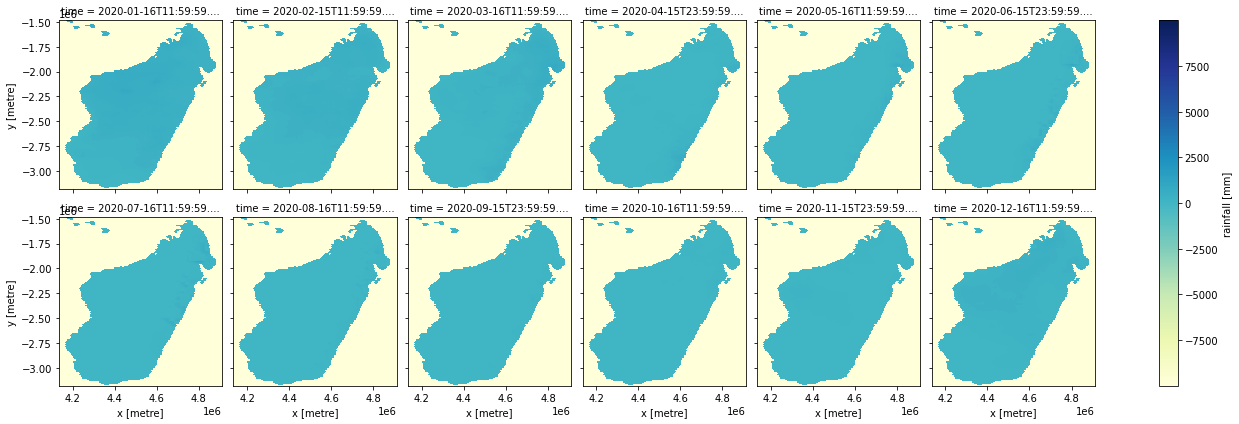

In [41]:
# set -9999 no-data values to NaN


# facet plot rainfall
NDVImasked.plot.imshow(col="time", col_wrap=6, cmap="YlGnBu", label=False)